# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [2]:
import pandas as pd
pcap = pd.read_csv("data/netfilx.csv")
pcap.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.168.43.72,128.93.77.234,DNS,77,Standard query 0xed0c A fonts.gstatic.com
1,2,0.000150,192.168.43.72,128.93.77.234,DNS,77,Standard query 0x301a AAAA fonts.gstatic.com
2,3,0.004726,192.168.43.72,128.93.77.234,DNS,87,Standard query 0x11d3 A googleads.g.doubleclic...
3,4,0.006522,192.168.43.72,128.93.77.234,DNS,87,Standard query 0x1284 AAAA googleads.g.doublec...
4,5,0.011103,192.168.43.72,128.93.77.234,DNS,78,Standard query 0x3432 AAAA ytimg.l.google.com
5,6,0.012354,192.168.43.72,128.93.77.234,DNS,96,Standard query 0xb756 A r4---sn-gxo5uxg-jqbe.g...
6,7,0.012474,192.168.43.72,128.93.77.234,DNS,75,Standard query 0x62ab A ssl.gstatic.com
7,8,0.012567,192.168.43.72,128.93.77.234,DNS,74,Standard query 0x42fb A www.google.com
8,9,0.319268,128.93.77.234,192.168.43.72,DNS,386,Standard query response 0x11d3 A 216.58.213.162
9,10,0.319288,192.168.43.72,128.93.77.234,DNS,75,Standard query 0x8756 A www.gstatic.com


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [3]:
import dnslib

NF_DOMAINS = (["nflxvideo", 
              "netflix", 
              "nflxso", 
              "nflxext"])

# Get the queries and responses that correspond to Netflix domains
nfre = '|'.join(NF_DOMAINS)
nf_queries = pcap[pcap['Info'].str.contains(nfre, regex=True, na=False) & pcap['Protocol'].str.contains('DNS')]
nf_queries.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info
86,87,1.828314,192.168.43.72,128.93.77.234,DNS,75,Standard query 0xb19a A www.netflix.com
87,88,1.828486,192.168.43.72,128.93.77.234,DNS,78,Standard query 0x3049 A assets.nflxext.com
88,89,1.828759,192.168.43.72,128.93.77.234,DNS,77,Standard query 0x5f60 A codex.nflxext.com
89,90,1.828993,192.168.43.72,128.93.77.234,DNS,86,Standard query 0x1f03 A customerevents.netflix...
90,91,1.829239,192.168.43.72,128.93.77.234,DNS,99,Standard query 0x7776 A ipv4-c001-cdg001-ix.1....
91,92,1.829530,192.168.43.72,128.93.77.234,DNS,99,Standard query 0x37e9 A ipv4-c024-cdg001-ix.1....
111,112,2.368868,192.168.43.72,128.93.77.234,DNS,99,Standard query 0x9415 A ipv4-c072-cdg001-ix.1....
118,119,2.369417,192.168.43.72,128.93.77.234,DNS,84,Standard query 0x6677 A occ-0-56-55.1.nflxso.net
1010,1011,11.262775,192.168.43.72,128.93.77.234,DNS,81,Standard query 0x5542 A push.prod.netflix.com
1515,1516,19.918496,192.168.43.72,128.93.77.234,DNS,99,Standard query 0x269f A ipv4-c005-cdg001-ix.1....


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [4]:
num = len(nf_queries)
mean = nf_queries['Length'].mean()
median = nf_queries['Length'].median()
n_pct = nf_queries['Length'].quantile(q=0.9)

print("Number of Packets: {}\nMean Length: {}\nMedian Length: {}\n90th Percentile: {}".format(num, mean, median, n_pct))

Number of Packets: 17
Mean Length: 86.70588235294117
Median Length: 84.0
90th Percentile: 99.0


**Write a brief justification for the features that you have chosen.**

I would select packet length. Packet number isn't tied to the packet's data itself, so it's an unhelpful feature. Since we did DNS filtering as apart of our data preparation, columns such as source and length, are the same between packets and would likely provide little to no helpful info for the model to make prediction. Time could be useful if we used to to calculate more relevent information, but as is it's not very informtive. Packet length provides insights on packet's content and could be relvent metric in making predicition using packet data.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [ ]:
num_segments = 0
nf_queries.sort_values(by=["Time"])

for i in range(1, len(nf_queries)):
    if nf_queries["Time"].iloc[i] - nf_queries["Time"].iloc[i-1] >= 1:
        num_segments += 1

time_elapsed = max(nf_queries["Time"]) - min(nf_queries["Time"])
segment_rate = num_segments / time_elapsed

print(f"Number of Segments: {num_segments}\n Time elapsed: {time_elapsed} \
        \n Segment Rate: {segment_rate}")

Number of Segments: 7
 Time elapsed: 429.29457700000006 
 Segment Rate: 0.01630581976813557


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File
Load the video dataset pickle file.

In [ ]:
import pickle as pkl
import pandas as pd

with open("netflix_dataset.pkl", "rb") as f:
    object = pkl.load(f)
# pd.read_pickle(path) // did not work either
    
df = pd.DataFrame(object)
df.head(10)

AttributeError: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/home/mariskakassi/.local/lib/python3.8/site-packages/pandas/_libs/internals.cpython-38-x86_64-linux-gnu.so'>

In [15]:
import pandas as pd

# NOTE: neither read_pickle and pickle.load were working due to version 
# incompatablities I was unable to resolve. As a sort-of-solution, I wrote the
# file "help.py" to convert the file into a csv "netflix_dataset.csv" and load 
# it in that way

dataset = pd.read_csv("netflix_dataset.csv")
dataset.head(10)

,Unnamed: 0,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
0,208,[[ 4380. ]\n [ 4380. ]\n [ 196...,148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
1,209,[[179260. ]\n [130204. ]\n [ 496...,91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
2,210,[[317962. ]\n [ 83192.4 ]\n [1708...,147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0
3,211,[[396800. ]\n [ 98961.6 ]\n [2469...,246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,...,0.0,0,0.186111,0.480556,netflix,False,False,False,False,12.0
4,212,[[325264. ]\n [331102.4 ]\n [3655...,336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,...,0.0,0,0.194444,0.472222,netflix,False,False,False,False,12.0
5,213,[[411400. ]\n [240875.2 ]\n [2562...,316355.2,324531.0,324531.0,374899.5,374899.5,399647.0,399647.0,412422.2,...,0.0,0,0.222222,0.444444,netflix,False,False,False,False,12.0
6,214,[[366138. ]\n [299565.2 ]\n [2201...,381471.4,350079.0,350079.0,490608.5,490608.5,545866.1,545866.1,569370.6,...,0.0,0,0.333333,0.444444,netflix,False,False,False,False,12.0
7,215,[[198244. ]\n [487900. ]\n [7132...,488343.0,526009.0,526009.0,601931.0,601931.0,689530.0,689530.0,740338.4,...,0.0,0,0.208333,0.625000,netflix,False,False,False,False,12.0
8,216,[[198242. ]\n [371104.4 ]\n [5486...,503673.8,599742.0,599742.0,620545.0,620545.0,633539.0,633539.0,641204.4,...,0.0,0,0.305556,0.361111,netflix,False,False,False,False,12.0
9,217,[[595364. ]\n [512436. ]\n [2730...,565869.8,615072.0,615072.0,635145.0,635145.0,652448.6,652448.6,695958.2,...,0.0,0,0.416667,0.416667,netflix,False,False,False,False,12.0


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [16]:
print(f"Original Dataset Size: {len(dataset)}")
valid = [240.0, 360.0, 480.0, 720.0, 1080.0]
filtered_dataset = dataset.loc[dataset["resolution"].isin(valid)]
print(f"Filtered Dataset Size: {len(filtered_dataset)}")

Original Dataset Size: 52279
Filtered Dataset Size: 49748


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [17]:
print(f"Original number of rows and columns: {filtered_dataset.shape}")
dropped_ds = filtered_dataset.drop(
                    ["deployment_session_id", "session_id", "video_id", 
                    "video_position", "home_id", "startup_time", "startup3.3", 
                    "startup6.6", "startup5", "startup10", "startup_mc", 
                    "serverAckFlags", "serverFinFlags", "serverRstFlags", 
                    "serverPshFlags", "serverSynFlags", "serverUrgFlags", 
                    "serverMaxRetransmit", "serverMinBytesInFlight", 
                    "serverMinBytesPerPacket", "serverMinInterArrivalTime", 
                    "serverMinRetransmit", "serverByteCount", 
                    "serverEndBytesPerPacket", "serverGoodput", 
                    "serverMaxBytesInFlight", "serverMaxBytesPerPacket", 
                    "serverStdBytesInFlight", "serverStdBytesPerPacket"]
                    , axis=1)

print(f"New number of rows and columns: {dropped_ds.shape}")


Original number of rows and columns: (49748, 252)
New number of rows and columns: (49748, 223)


**Briefly explain why you removed those columns.**

I removed the identifying columns (deployment_session_id", "session_id", "video_id", "video_position", "home_id") because they were relative to the session itself, meaning it's specific to the session itself, making it irrelvent to video quality. I removed all the server assoicated columns because those were all specific to the sever instead of the video quality itself. I think it could be argued whether or not the startup times should be kept, but I decided to remove them because startup time might not be that relevent during playback time.

(NOTE: later on in the data preparation, I will drop all columns that are of the
object datatype. I did this because my classifier could not process object data.
This is not always a good decision in practice. I should try to turn my object data into something the models can take in, but I wasn't able to. As a result, I couldn't use the data used in the "10_EWMA_chunksizes" column, that could be relevent to video quality prediction.)

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [18]:
dropped_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49748 entries, 0 to 52277
Columns: 223 entries, Unnamed: 0 to service
dtypes: bool(2), float64(159), int64(59), object(3)
memory usage: 84.4+ MB


In [19]:
# Preparing Data
df = dropped_ds.select_dtypes(exclude=['object'])
df = df.dropna()

# Identifying Features and Label
X = df.drop(["resolution"], axis=1)
y = df["resolution"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [20]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)
# RandomForestClassifier(max_depth=3, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [21]:
from sklearn.model_selection import cross_val_score
results = []
estimators = [1, 3, 5, 8, 10]
depth_options = [2, 3, 5, 8]


for val in estimators:
    for depth in depth_options:
        model = RandomForestClassifier(n_estimators=val, max_depth=depth)
        model.fit(X_train, y_train)
        scores = cross_val_score(model, X_train, y_train, cv=5)
        results.append((val, depth, scores.mean(), scores.std()))
        print("at n=%0.2f d=%0.2f : %0.2f accuracy with a standard deviation of %0.2f" % (val, depth, scores.mean(), scores.std()))

at n=1.00 d=2.00 : 0.69 accuracy with a standard deviation of 0.01
at n=1.00 d=3.00 : 0.72 accuracy with a standard deviation of 0.04
at n=1.00 d=5.00 : 0.79 accuracy with a standard deviation of 0.02
at n=1.00 d=8.00 : 0.84 accuracy with a standard deviation of 0.02
at n=3.00 d=2.00 : 0.70 accuracy with a standard deviation of 0.01
at n=3.00 d=3.00 : 0.75 accuracy with a standard deviation of 0.02
at n=3.00 d=5.00 : 0.83 accuracy with a standard deviation of 0.02
at n=3.00 d=8.00 : 0.87 accuracy with a standard deviation of 0.01
at n=5.00 d=2.00 : 0.72 accuracy with a standard deviation of 0.03
at n=5.00 d=3.00 : 0.75 accuracy with a standard deviation of 0.01
at n=5.00 d=5.00 : 0.82 accuracy with a standard deviation of 0.01
at n=5.00 d=8.00 : 0.87 accuracy with a standard deviation of 0.01
at n=8.00 d=2.00 : 0.72 accuracy with a standard deviation of 0.01
at n=8.00 d=3.00 : 0.77 accuracy with a standard deviation of 0.01
at n=8.00 d=5.00 : 0.83 accuracy with a standard deviation of 

In [27]:
max_tuple = max(results, key=lambda x: x[2])
print(max_tuple)
print("I will chose the parameters that resulted in the maximum accuracy.\n \
      This might be a faulty choice as it could be overfitting as I'm chosing\n \
      the maximum values for either parameter, but in this case I will trust that\n \
      the cross validation will help curb it and the accuracy isn't insanely high")

(10, 8, 0.8834060415697881, 0.004219620581937653)
I will chose the parameters that resulted in the maximum accuracy.
       This might be a faulty choice as it could be overfitting as I'm chosing
       the maximum values for either parameter, but in this case I will trust that
       the cross validation will help curb it and the accuracy isn't insanely high


In [23]:
model = RandomForestClassifier(n_estimators=10, max_depth=8)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=10)

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

 Accuracy: 0.8791506193400646
 F1 Score: 0.8111880595994402
 ROC/AUC: 0.9767955203212871


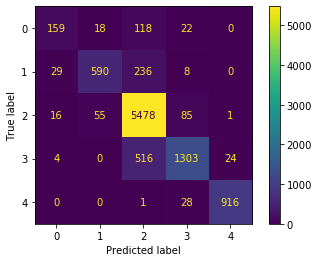

In [24]:
from sklearn.metrics import accuracy_score,  f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

y_pred_prob = model.predict_proba(X_test)
ROC_AUC = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

print(f" Accuracy: {accuracy}\n F1 Score: {f1}\n ROC/AUC: {ROC_AUC}")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


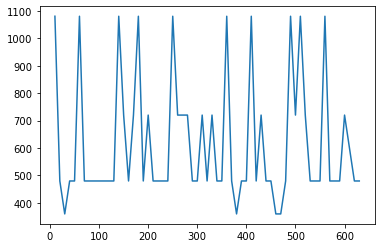

In [25]:
import matplotlib.pyplot as plt

# only using unique values, so we have one resolution per 10 second time stamp
testing = X_test.drop_duplicates(subset=['relative_timestamp'])
testing = testing.sort_values(by='relative_timestamp', ascending=True)
predition = model.predict(testing)
plt.plot(testing['relative_timestamp'], predition)